In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction

__LightGBM__ is a gradient boosting framework that uses tree based learning algorithms. It is designed and efficient with the following advantages:


- faster training speed and higher efficiency;


- lower memory usage;


- better accuracy;


- support of parallel and GPU learning;


- capable of handling large-scale data.

## LightGBM intuition

__LightGBM__ grows tree vertically while other tree based learning algorithms grow trees horizontally. 


- It means that LightGBM grows tree leaf-wise while other algorithms grow level-wise. It will choose the leaf with the max delta loss to grow. When growing the same leaf, leaf-wise algorithm can reduce more loss than a level-wise algorithm.


- so, we need to understand the distinction between leaf-wise tree growth and level-wise tree growth.

### Important points about tree-growth

- If we grow the full tree, __best-first (leaf-wise)__ and __depth-first (level_wise)__ will result in the same tree. The difference is in the order in which the tree is expanded. Since we don't normally grow trees to their full depth, order matters. 


- Application of early stopping criteria and pruning methods can result in very different trees. Because leaf-wise chooses splits based on their contribution to the global loss and not just the loss along a particular branch, it often (not always) will learn lower-error trees 'faster' than level-wise.


- For a small number of nodes, leaf-wise will probably out-perform level-wise. As we add more nodes, without stopping or pruning they will converge to the same performance because they will literally build the same tree eventually.

## LightGBM Parameters

### Control Parameters

- __max_depth__: it describes the maximum tree depth. This parameter is used to handle overfitting. If the model is overfitted, you should lower max_depth.


- __min_data_in_leaf__: it's the minimum number of records a leaf may have. The default value is 20, optimal value. It's also used to deal with overfitting.


- __feature_fraction__: used when your boosting is random forest. 0.8 feature fraction means LightGBM will select 80% of parameters randomly in each iteration for building trees.


- __bagging_fraction__: specifies the fraction of data to be used for each iteration and is generally used to speed up the training and avoid overfitting. 


- __early_stopping_round__: this parameter can help you speed up your analysis. Model will stop training if one metric of one validation data doesn't improve in last early_stopping_round rounds. This will reduce excessive iterations.


- __lambda__: lambda specifies regularization. Typical value ranges from 0 to 1.


- __min_gain_to_split__: This parameter will describe the minimum gain to make a split. It can be used to control the number of useful splits in the tree.


- __max_cat_group__: when the number of categories is big, finding the split point on it is easily over-fitting. So LightGBM merges them into 'max_cat_group' groups, and finds the split points on the group boundaries, default:64.

### Core Parameters

- __Task__: it specifies the task you want to perform on data. It may be either train or predict.


- __application__: specifies the application of your model, whether it is a regression problem or a classification problem. LightGBM will by default consider the model as a regression model.
    
    - regression;
    - classification: binary classification;
    - multiclass: for multiclass classification
    
    
- __boosting__: defines the type of algorithm you want to run, default=gdbt.

    - __gbdt__: traditional Gradient Boosting Decision Tree;
    - __rf__: random forest;    
    - __dart__: Dropouts meet Multiple Additive Regression Trees;    
    - __goss__: Gradient-based One-Side Sampling.
    
    
- __num_boost_round__: Number of boosting iterations, typically 100+;


- __learning_rate__: this determines the impact of each tree on the final outcome. GBM works by starting with an initial estimate which is updated using the output of each tree. The learning parameter controls the magnitudeof this change in the estimates. Typical values: 0.1, 0.001, 0.003...


- __num_leaves__: number of leaves in the full tree, default:31;


- __device__: default: cpu, can also pass gpu.

### Metric Parameter

- it specifies the loss for model building. Below are a few general losses for regression and classification:

    - __mae__: mean absolute error;
    - __mse__: mean squared error;
    - __binary_logloss__: loss for binary classification;
    - __multi_logloss__: loss for multi classification.

### IO Parameter

- __max_bin__: it denotes the maximum number of bin that feature value will bucket in.


- __categorical_feature__: it denotes the index of categorical features. If categorical_features=0,1,2 then column 0, column 1 and column 2 are categorical variables.


- __ignore_column__: same as categorical_features but instead of considering specific columns as categorical, it will completely ignore them.


- __save_binary__: if you are really dealing with the memory size of your data file then specify this parameter as 'True'. Specifying this parameter true will save the dataset to binary file, this binary file will speed your data reading time for the next time. 

# LightGBM implementation in Python

In [2]:
df = pd.read_csv('./raw_data/Breast_cancer_data.csv')
df.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


## data exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_radius      569 non-null    float64
 1   mean_texture     569 non-null    float64
 2   mean_perimeter   569 non-null    float64
 3   mean_area        569 non-null    float64
 4   mean_smoothness  569 non-null    float64
 5   diagnosis        569 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 26.8 KB


In [6]:
df.isna().sum()

mean_radius        0
mean_texture       0
mean_perimeter     0
mean_area          0
mean_smoothness    0
diagnosis          0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,1.000000


__Comments__:

- there are 6 variables in the dataset: 'mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness' and 'diagnosis'. 'diagnosis' will be our target, the other 5 might be our features.


- all 5 features are numerical and are defined as type 'float' while the target is defined as 'int'.


- there are no NaN values and no duplicated rows.

## define X and y

In [20]:
X = df.drop(columns='diagnosis', axis=1)
y = df['diagnosis']

## check distribution of the target

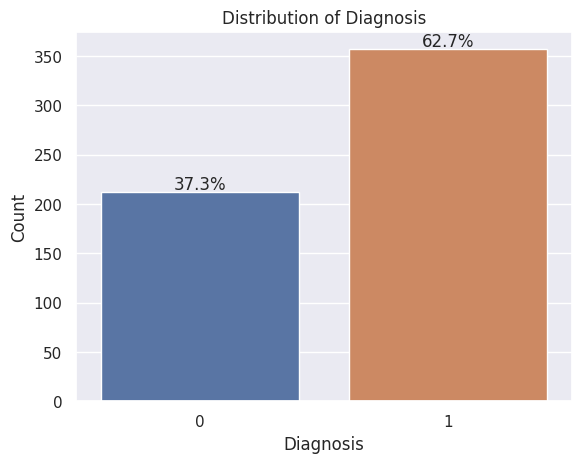

In [21]:
sns.set(style="darkgrid")
ax = sns.countplot(x='diagnosis', data=df)

total = len(df['diagnosis'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 3,
            '{:.1f}%'.format((height/total) * 100),
            ha="center")

plt.title('Distribution of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

__Comments__:

- the target is 'diagnosis' and it contains 2 values: 0 and 1


- 0 is for __Negative prediction__ and 1 is for __Positive prediction__.


- it's a __binary classification__ task.

## create train and test sets

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (398, 5)
y_train shape: (398,)
X_test shape: (171, 5)
y_test shape: (171,)


## LightGBM model

In [23]:
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 249, number of negative: 149
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 665
[LightGBM] [Info] Number of data points in the train set: 398, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625628 -> initscore=0.513507
[LightGBM] [Info] Start training from score 0.513507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

LGBMClassifier()

In [26]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)

print(f'LightGBM model accuracy score: {round(accuracy,4)}')

LightGBM model accuracy score: 0.9532


## compare train and test sets accuracy

In [27]:
y_pred_train = clf.predict(X_train)

print(f'Train set accuracy score: {round(accuracy_score(y_train, y_pred_train),4)}')

Train set accuracy score: 1.0


- Since train and test sets accuracy are quite comparable, we cannot say the model is overfitting.

## confusion matrix

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n{cm}')
print(f'\nTrue Positives(TP): {cm[0,0]}')
print(f'\nTrue Negatives(TN): {cm[1,1]}')
print(f'\nFalse Positives(TP): {cm[0,1]}')
print(f'\nFalse Negatives(FN): {cm[1,0]}')

Confusion matrix:
[[ 61   2]
 [  6 102]]

True Positives(TP): 61

True Negatives(TN): 102

False Positives(TP): 2

False Negatives(FN): 6


<AxesSubplot:>

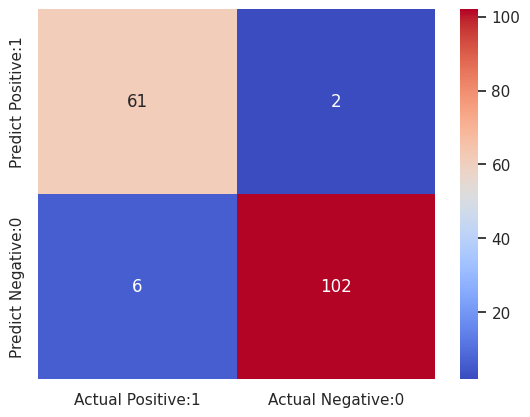

In [51]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='coolwarm')

## classification metrices

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        63
           1       0.98      0.94      0.96       108

    accuracy                           0.95       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.95      0.95      0.95       171



## LightGBM Parameter Tuning

- __num_leaves__: this is the main parameter to control the complexity of the tree model. Ideally, the value of num_leaves should be less than or equal to 2^(max_depth). A value higher than this will result in overfitting. 


- __min_data_in_leaf__: setting it to a large value can avoid growing too deep a tree, but may cause underfitting. In practice, setting it to hundreds or thousands is enough for a large dataset.


- __max_depth__: we can also use max_depth to limit the tree depth explicitly.

### For Faster Speed

- use bagging by setting __bagging_fraction__ and __baging_freq__.
- use feature sub-sampling by setting __feature_fraction__.
- use small __max_bin__.
- use __save_binary__ to speed up data loading in future learning.